# Resnet with just Class 0 and 7

## Setup Parameters and Load Data

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import sklearn
import math
import tensorflow_addons as tfa
import pandas as pd
import seaborn as sns

np.set_printoptions(precision=2)
pd.options.display.float_format = "{:,.2f}".format

# Define constants
RANDOM_STATE = 4242
NUM_CLASSES = 2
MAX_EPOCHS = 1000
EARLY_STOPPING_PATIENCE = 50
BASE_LEARNING_RATE = 0.001
BATCH_SIZE = 64

In [2]:
AUTOTUNE = tf.data.AUTOTUNE

# Split should always be identical as long as this line of code isn't changed.
train_ds, validation_ds, test_ds = tfds.load('deep_weeds', as_supervised= True, shuffle_files= True, split=["train[:70%]", "train[70%:90%]", "train[90%:100%]"])

#Pre-Processing
# Keep on instances of either class 0 or 7
def filter_classes(img, label):
    return (label == 0 or label == 7)

# Renumbers class 7 as class 1
def renumber_classes(img, label):
    if label == 7:
        return (img, tf.constant(1, dtype = tf.int64))
    else:
        return (img, label)

train_ds = train_ds.filter(filter_classes)
validation_ds = validation_ds.filter(filter_classes)
test_ds = test_ds.filter(filter_classes)

train_ds = train_ds.map(renumber_classes)
validation_ds = validation_ds.map(renumber_classes)
test_ds = test_ds.map(renumber_classes)

train_ds = train_ds.batch(BATCH_SIZE)
validation_ds = validation_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

train_ds = train_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
validation_ds = validation_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()
test_ds = test_ds.shuffle(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE).cache()

2021-11-25 08:09:44.780214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 08:09:44.790179: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 08:09:44.790846: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-25 08:09:44.792426: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [3]:
def loadDatasetEagerly(ds):
    ds_numpy = tfds.as_numpy(ds)
    X_batches = []
    y_batches = []
    for X_batch, y_batch in ds_numpy:
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    X_batches = tuple(X_batches)
    y_batches = tuple(y_batches)
    X = np.concatenate(X_batches, axis = 0)
    y = np.concatenate(y_batches, axis = 0)
    return X, y

In [4]:
# Check if the dataset was filtered correctly
X_train, y_train = loadDatasetEagerly(train_ds)
print(X_train.shape, y_train.shape)
print(np.unique(y_train, return_counts = True))

del X_train
del y_train

2021-11-25 07:10:03.900783: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


(1449, 256, 256, 3) (1449,)
(array([0, 1]), array([769, 680]))


## Model Definition

In [5]:
base_model = tf.keras.models.load_model('resnet_finetuned_model')
base_model.trainable = False

base_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [6]:
# Remove the old output layer, and attach a new output layer containing only one node
output_layer = tf.keras.layers.Dense(1, activation = 'sigmoid')

base_output = base_model.layers[len(base_model.layers) - 2].output
output = output_layer(base_output)
model = tf.keras.models.Model(inputs=base_model.inputs, outputs=output)

adam = tf.keras.optimizers.Adam(learning_rate = BASE_LEARNING_RATE)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['Precision', 'Recall', 'accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [7]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01, 
                                                  patience = EARLY_STOPPING_PATIENCE, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

history = model.fit(train_ds, validation_data = validation_ds, 
                    epochs = MAX_EPOCHS, callbacks = [early_stopping, reduce_lr], batch_size = BATCH_SIZE)

Epoch 1/1000


2021-11-25 07:10:21.444910: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


12/12 [==============================] - 31s 1s/step - loss: 0.4538 - precision: 0.7910 - recall: 0.7456 - accuracy: 0.7881 - val_loss: 0.3598 - val_precision: 0.8593 - val_recall: 0.8261 - val_accuracy: 0.8609
Epoch 2/1000
12/12 [==============================] - 9s 734ms/step - loss: 0.2567 - precision: 0.9034 - recall: 0.8941 - accuracy: 0.9055 - val_loss: 0.2820 - val_precision: 0.8250 - val_recall: 0.9565 - val_accuracy: 0.8891
Epoch 3/1000
12/12 [==============================] - 8s 709ms/step - loss: 0.1863 - precision: 0.9366 - recall: 0.9559 - accuracy: 0.9489 - val_loss: 0.2302 - val_precision: 0.8722 - val_recall: 0.9565 - val_accuracy: 0.9174
Epoch 4/1000
12/12 [==============================] - 8s 693ms/step - loss: 0.1560 - precision: 0.9488 - recall: 0.9529 - accuracy: 0.9538 - val_loss: 0.2125 - val_precision: 0.8722 - val_recall: 0.9565 - val_accuracy: 0.9174
Epoch 5/1000
12/12 [==============================] - 8s 686ms/step - loss: 0.1268 - precision: 0.9647 - recall

In [8]:
from sklearn.metrics import classification_report

def plotResults(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    precision = hist.history['precision']
    val_precision = hist.history['val_precision']
    recall = hist.history['recall']
    val_recall = hist.history['val_recall']

    # Plot the graph manually
    epochs = range(len(loss))

    plt.figure(figsize=(20, 20))
    plt.subplot(4, 1, 1)
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Validation Loss')
    plt.title('Training and validation loss')
    plt.legend()

    plt.subplot(4, 1, 2)
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(4, 1, 3)
    plt.plot(epochs, precision, 'r', label='Training Precision')
    plt.plot(epochs, val_precision, 'b', label='Validation Precision')
    plt.title('Training and validation Precision')
    plt.legend()

    plt.subplot(4, 1, 4)
    plt.plot(epochs, recall, 'r', label = "Training Recall")
    plt.plot(epochs, val_recall, 'b', label='Validation Recall')
    plt.title('Training and validation Recall')
    plt.legend()

    plt.show()
    
def loadDatasetEagerly(ds):
    ds_numpy = tfds.as_numpy(ds)
    X_batches = []
    y_batches = []
    for X_batch, y_batch in ds_numpy:
        X_batches.append(X_batch)
        y_batches.append(y_batch)
    X_batches = tuple(X_batches)
    y_batches = tuple(y_batches)
    X = np.concatenate(X_batches, axis = 0)
    y = np.concatenate(y_batches, axis = 0)
    return X, y
    
def printClassificationReport(model, val_ds):
    # Convert validation dataset into X_val, y_val
    X_val, y_val = loadDatasetEagerly(val_ds)
    
    # Print classification report
    #y_val = np.argmax(y_val, axis=1) # Convert one-hot to index
    y_pred = model.predict(X_val)
    y_pred = np.where(y_pred > 0.5, 1, 0)
    #print(y_pred)
    #y_pred = np.argmax(y_pred, axis=1) # Convert one-hot to index
    print(classification_report(y_val, y_pred))

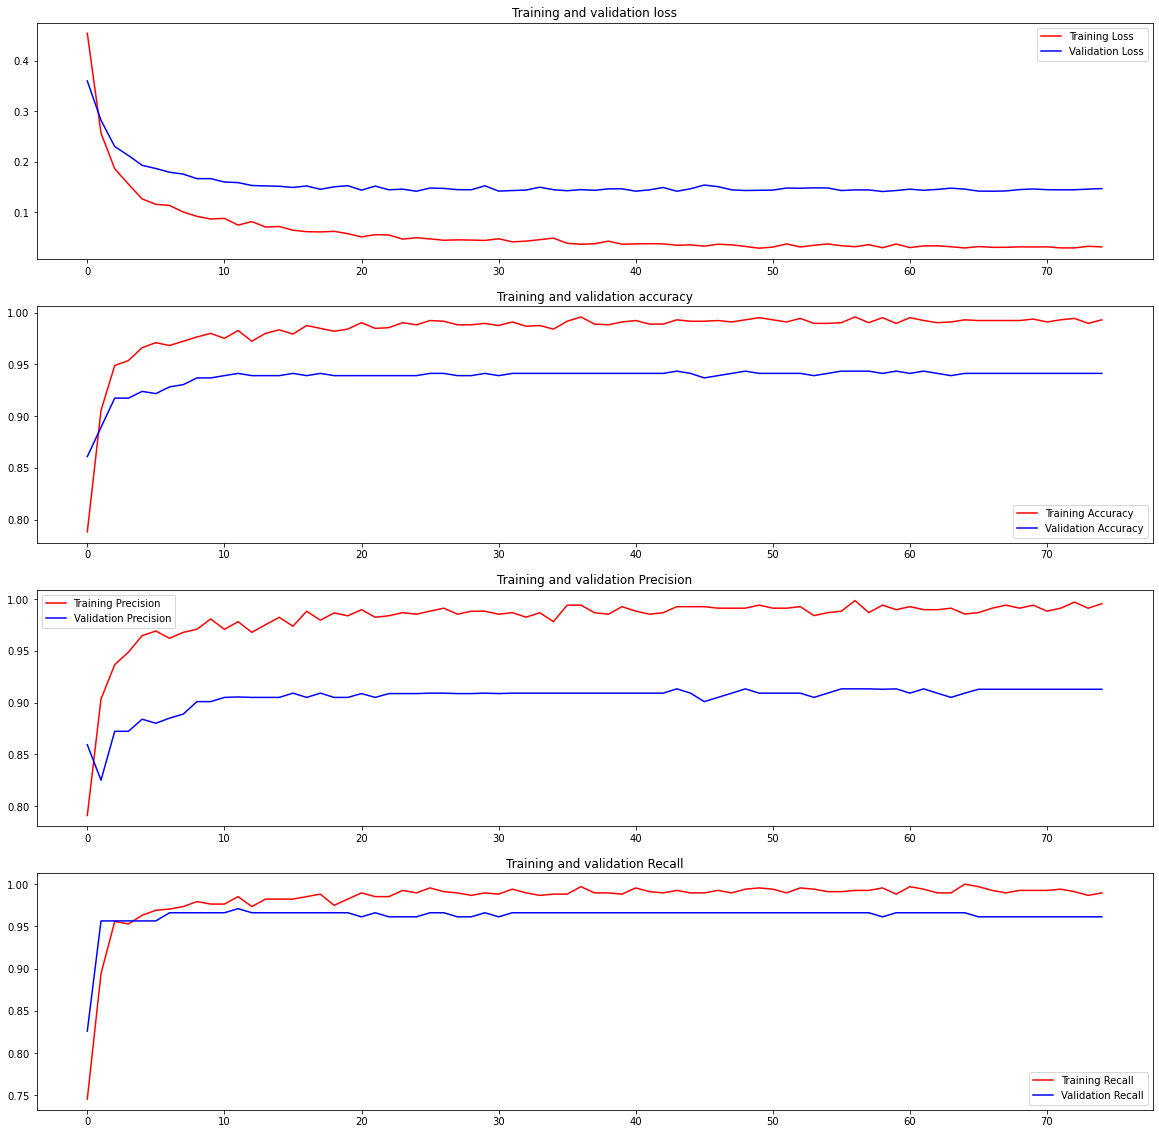

              precision    recall  f1-score   support

           0       0.97      0.92      0.94       253
           1       0.91      0.96      0.93       207

    accuracy                           0.94       460
   macro avg       0.94      0.94      0.94       460
weighted avg       0.94      0.94      0.94       460



In [20]:
plotResults(history)
printClassificationReport(model, validation_ds)

In [ ]:
model.save('resnet_specific_model')

!zip -r resnet_specific_model.zip resnet_specific_model

### Finetuning

In [4]:
model = tf.keras.models.load_model('resnet_specific_model')
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [5]:
# Unfreeze the base_model. Note that it keeps running in inference mode
# since we passed `training=False` when calling it. This means that
# the batchnorm layers will not update their batch statistics.
# This prevents the batchnorm layers from undoing all the training
# we've done so far.

FINETUNING_MODIFIER = 1/50

base_model = model.get_layer('resnet50')

base_model.trainable = True
adam = tf.keras.optimizers.Adam(learning_rate = BASE_LEARNING_RATE * FINETUNING_MODIFIER)

model.compile(optimizer = adam, loss = 'binary_crossentropy', metrics = ['Precision', 'Recall', 'accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 256, 256, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 256, 256, 3)       0         
_________________________________________________________________
tf.__operators__.getitem (Sl (None, 256, 256, 3)       0         
_________________________________________________________________
tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)       0         
_________________________________________________________________
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0     

In [6]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', min_delta = 0.01, 
                                                  patience = EARLY_STOPPING_PATIENCE, restore_best_weights = True)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.6,
                              patience=5, cooldown=10, verbose = 1)

finetuning_hist = model.fit(train_ds, validation_data = validation_ds, 
                    epochs = MAX_EPOCHS, callbacks = [early_stopping, reduce_lr], batch_size = BATCH_SIZE)

Epoch 1/1000


2021-11-25 08:10:20.610808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-25 08:10:25.545250: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


23/23 [==============================] - 41s 1s/step - loss: 0.0862 - precision: 0.9608 - recall: 0.9721 - accuracy: 0.9683 - val_loss: 0.1425 - val_precision: 0.9497 - val_recall: 0.9130 - val_accuracy: 0.9391
Epoch 2/1000
23/23 [==============================] - 21s 925ms/step - loss: 0.0463 - precision: 0.9838 - recall: 0.9838 - accuracy: 0.9848 - val_loss: 0.1996 - val_precision: 0.8973 - val_recall: 0.9710 - val_accuracy: 0.9370
Epoch 3/1000
23/23 [==============================] - 21s 911ms/step - loss: 0.0328 - precision: 0.9882 - recall: 0.9853 - accuracy: 0.9876 - val_loss: 0.3066 - val_precision: 0.8333 - val_recall: 0.9903 - val_accuracy: 0.9065
Epoch 4/1000
23/23 [==============================] - 21s 914ms/step - loss: 0.0381 - precision: 0.9867 - recall: 0.9853 - accuracy: 0.9869 - val_loss: 0.2684 - val_precision: 0.8542 - val_recall: 0.9903 - val_accuracy: 0.9196
Epoch 5/1000
23/23 [==============================] - 21s 923ms/step - loss: 0.0309 - precision: 0.9897 - re

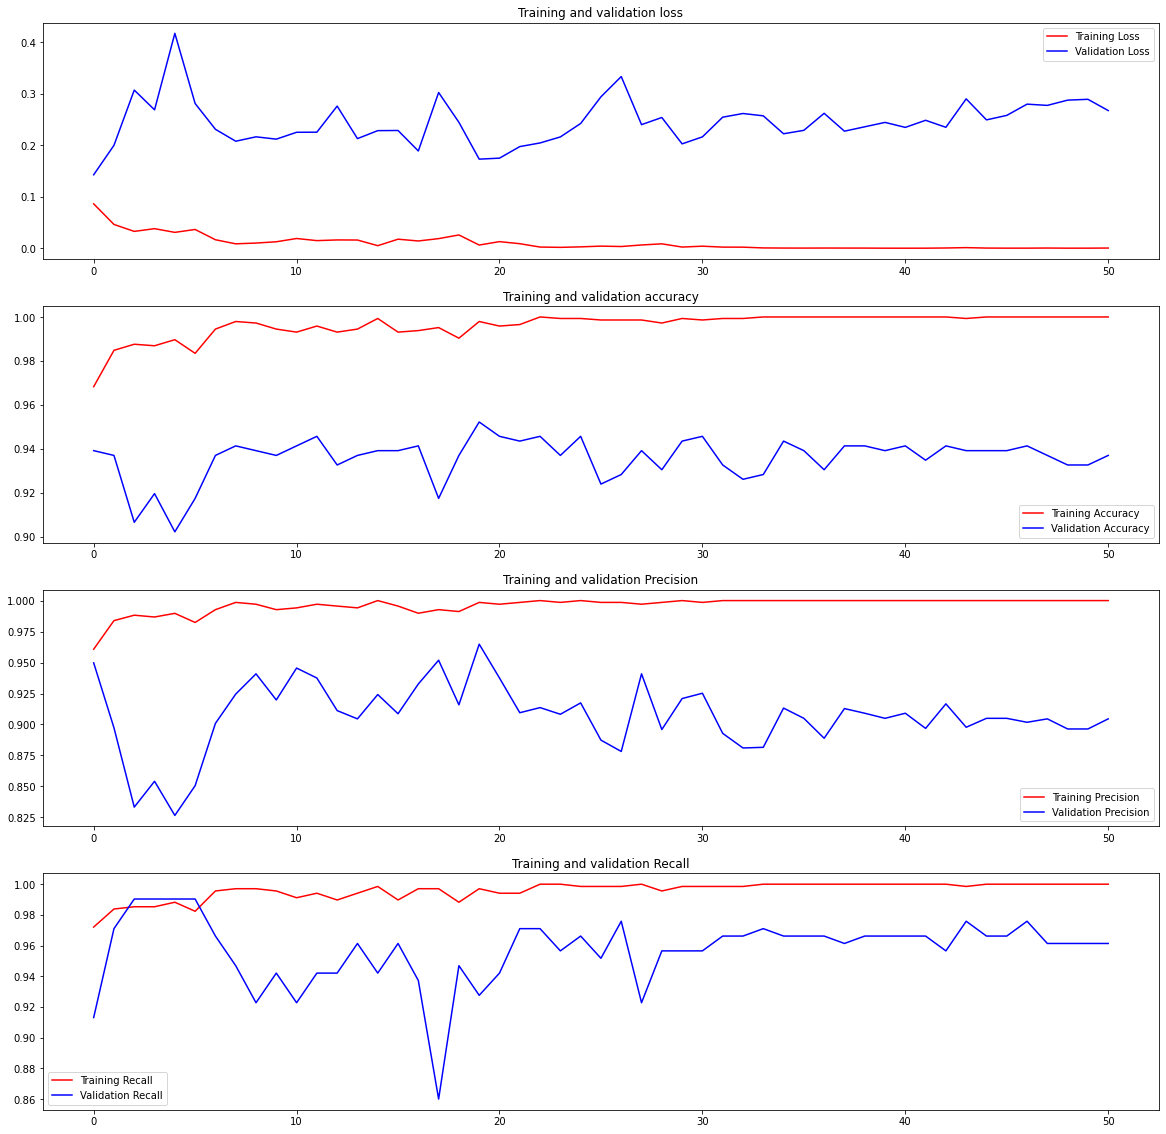

              precision    recall  f1-score   support

           0       0.93      0.96      0.95       253
           1       0.95      0.91      0.93       207

    accuracy                           0.94       460
   macro avg       0.94      0.94      0.94       460
weighted avg       0.94      0.94      0.94       460



In [10]:
plotResults(finetuning_hist)
printClassificationReport(model, validation_ds)